In [1]:
# Imports
import Transformer
from tensorflow.keras.optimizers import Adam

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, LastDimensionNormalizer, Batcher
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
from Quaternion_functions import quaternion_to_euler_angle_vectorized1
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

import ahrs

In [2]:
#folder = str("../logs/20201002_10_16_28/") # Y up - Stand still
folder_calib = str("../logs/20201002_10_17_42/")  # Y up - Calib for Magneto
folder_test  = str("../logs/20201002_10_19_33/")  # Y up - General Test

folder_test = str("../logs/20200829_12_37_57/") # 2D yesNoise no Periodic yesRot
folder_test = str("../logs/20200829_12_05_54/") # 1D yesNoise yesPeriodic no Rot
folder_test = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható
#folder_test = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
#file = str("../logs/20201002_11_07_24/") # Y up - Training data

d = DataStream(folder_test)
c = DataStream(folder_calib)

d.calibrateMag(c)

In [3]:
print('d.data shape: ' + str(d.data.shape))
d.showHeader()

d.filterData(31, 'hanning', [1, 2, 3]) # filter Acc
d.filterData(31, 'hanning', [4, 5, 6]) # filter Gyro
d.filterData(31, 'hanning', [7, 8, 9]) # filter Mag
#d.plotData(acc=True,gyro=True,mag=True)

Acc    = d.data[:,1:4]
Gyro   = d.data[:,4:7]
Mag    = d.data[:,7:10]
MocapQ = d.data[:,13:17]
MocapE = d.data[:,17:20]

d.data shape: (61725, 20)
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatW
14 - MARG_quatX
15 - MARG_quatY
16 - MARG_quatZ
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ


In [4]:
MadgwickQ = ahrs.filters.Madgwick(acc=Acc*9.8077, gyr=Gyro/57.3, mag=Mag*10, gain=0.041, Dt=0.004) #q0=q_init #az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickQ.Q.shape))                        #gain = 0.000001



MadgwickQ shape: (61725, 4)


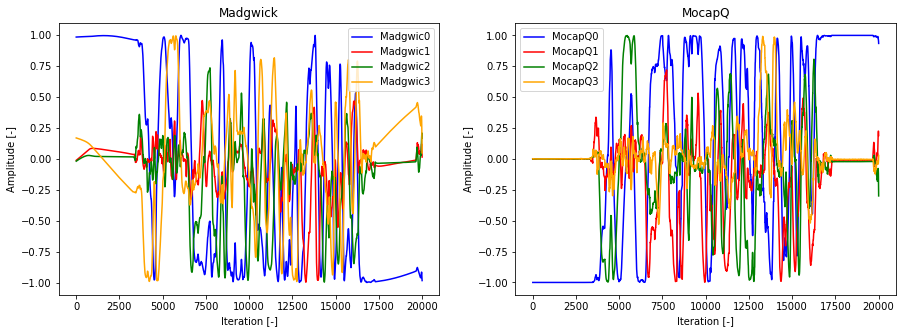

In [26]:
start = 0
end = 20000

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q[start:end,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q[start:end,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q[start:end,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ[start:end,0], color='blue', label='MocapQ0')
#plt.plot(MadgwickQ.Q[start:end,0], color='blue', label='Madgwic0')
plt.plot(MocapQ[start:end,1], color='red', label='MocapQ1')
plt.plot(MocapQ[start:end,2], color='green', label='MocapQ2')
plt.plot(MocapQ[start:end,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

In [6]:
def qprod(a, b):
    '''Quaternion multiplication.'''
    w=a[0]*b[0]-a[1]*b[1]-a[2]*b[2]-a[3]*b[3]
    x=a[0]*b[1]+a[1]*b[0]+a[2]*b[3]-a[3]*b[2]
    y=a[0]*b[2]+a[2]*b[0]-a[1]*b[3]+a[3]*b[1]
    z=a[0]*b[3]+a[3]*b[0]+a[1]*b[2]-a[2]*b[1]
    q=[]
    q.append(w)
    q.append(x)
    q.append(y)
    q.append(z)

    return q

def invq(a):
    w = a[0]
    x = a[1]* -1
    y = a[2]* -1
    z = a[3]* -1
    q = np.zeros(4)
    q[0] = w
    q[1] = x
    q[2] = y
    q[3] = z
    
    return q
    

In [7]:
#MadgwickQ.Q = w_flip(MadgwickQ.Q)
print(MadgwickQ.Q[0])
mad = MadgwickQ.Q[20300]
moc = MocapQ[20300]

mad = invq(mad)
moc = invq(moc)


MadgwickQ.Q_rel = np.zeros((len(MadgwickQ.Q),4))
MocapQ_rel = np.zeros((len(MocapQ),4))

print(MadgwickQ.Q[0])

for i in range(len(MadgwickQ.Q)):
    MadgwickQ.Q_rel[i] = qprod(MadgwickQ.Q[i],mad)
    MocapQ_rel[i] = qprod(MocapQ[i],moc)
    
print(MadgwickQ.Q[0])



[ 0.98532401 -0.01175066 -0.01857678  0.16927322]
[ 0.98532401 -0.01175066 -0.01857678  0.16927322]
[ 0.98532401 -0.01175066 -0.01857678  0.16927322]


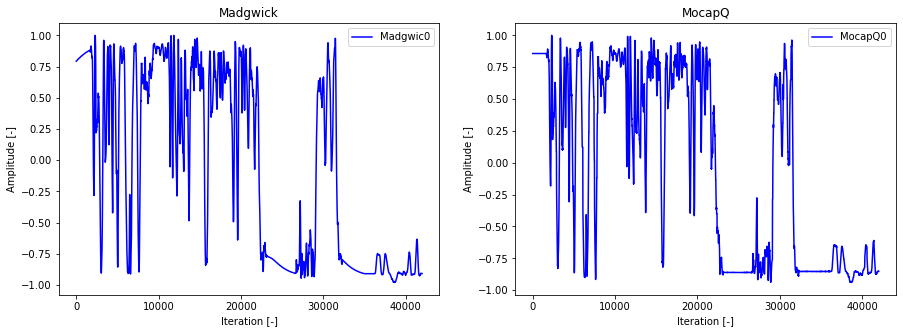

In [8]:
start = 18000
end = 60000

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0')
#plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1')
#plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2')
#plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
#plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
#plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
#plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

#c, loss = findw(MadgwickQ.Q_rel[0])

In [9]:
import sympy
import math


In [10]:
#855, 1775, 2645
#4500, 5000, 5500 (0.1-nél)
from Quaternion_functions import qprod

f = 21000
s = 23000
t = 34000

mad1 = MadgwickQ.Q_rel[f,1:]
mad2 = MadgwickQ.Q_rel[s,1:]
mad3 = MadgwickQ.Q_rel[t,1:]

#mad1[3] = mad1[3]* -1
#mad2[3] = mad2[3]* -1
#mad3[3] = mad3[3]* -1

moc1 = MocapQ_rel[f,1:]
moc2 = MocapQ_rel[s,1:]
moc3 = MocapQ_rel[t,1:]

#mad = qprod( qprod(mad1, mad2), mad3)
#moc = qprod( qprod(moc1, moc2), moc3)

print(mad)
print(moc)
moc = [moc,moc]
mad = [mad, mad]

[-0.68627734 -0.21068833  0.34762957 -0.60314801]
[ 0.85578817  0.34765905 -0.21807858  0.31491405]


In [11]:
print(mad1)
print(mad2)
print(mad3)

print(moc1)
print(moc2)
print(moc3)

[ 0.14685584  0.38894621 -0.30032436]
[-0.25088676  0.22609833 -0.5839154 ]
[0.51497344 0.38806109 0.74830018]
[-0.51153048  0.27805116 -0.16680562]
[-0.06897744  0.54956981 -0.34427727]
[-0.63561357 -0.73999221  0.20396086]


In [12]:
import sympy

a = sympy.Symbol('a')
b = sympy.Symbol('b')
c = sympy.Symbol('c')
d = sympy.Symbol('d')
e = sympy.Symbol('e')
f = sympy.Symbol('f')
g = sympy.Symbol('g')
h = sympy.Symbol('h')
i = sympy.Symbol('i')

#[a,b,c
# d,e,f
# g,h,i]

eq1 = mad1[0] * a + mad1[1] * b + mad1[2] * c - moc1[0]
eq2 = mad1[0] * d + mad1[1] * e + mad1[2] * f - moc1[1]
eq3 = mad1[0] * g + mad1[1] * h + mad1[2] * i - moc1[2]

eq4 = mad2[0] * a + mad2[1] * b + mad2[2] * c - moc2[0]
eq5 = mad2[0] * d + mad2[1] * e + mad2[2] * f - moc2[1]
eq6 = mad2[0] * g + mad2[1] * h + mad2[2] * i - moc2[2]

eq7 = mad3[0] * a + mad3[1] * b + mad3[2] * c - moc3[0]
eq8 = mad3[0] * d + mad3[1] * e + mad3[2] * f - moc3[1]
eq9 = mad3[0] * g + mad3[1] * h + mad3[2] * i - moc3[2]



sol=(sympy.nsolve((eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9), (a,b,c,d,e,f,g,h,i),(0,0,0,0,0,0,0,0,0),verify=False))
print(sol)


Matrix([[-0.933046205154426], [-0.801854338368321], [0.208537837459399], [0.0492499728282231], [-0.0667359824186147], [-0.988182309087350], [0.533627825463989], [-0.502310761189903], [0.165821103985994]])


In [13]:
solution = np.array([[sol[0], sol[1], sol[2]], [sol[3], sol[4], sol[5]], [sol[6], sol[7], sol[8]]])
print(solution)
print(np.matmul(solution, [[0],[0],[1]]))

[[-0.933046205154426 -0.801854338368321 0.208537837459399]
 [0.0492499728282231 -0.0667359824186147 -0.988182309087350]
 [0.533627825463989 -0.502310761189903 0.165821103985994]]
[[0.208537837459399]
 [-0.988182309087350]
 [0.165821103985994]]


In [14]:
for i in range(len(MadgwickQ.Q_rel)):
    MadgwickQ.Q_rel[i, 1:] = np.matmul(solution, MadgwickQ.Q_rel[i, 1:])

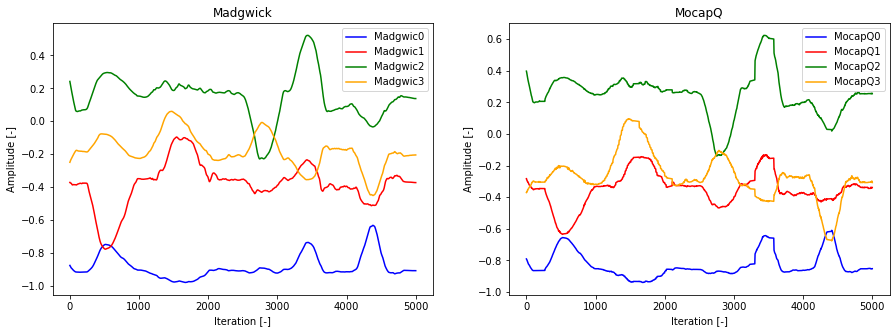

In [21]:
start = 55000
end = 60000

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
#plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0',linestyle= '--')
#plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1',linestyle='--')
#plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2',linestyle= '--')
#plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

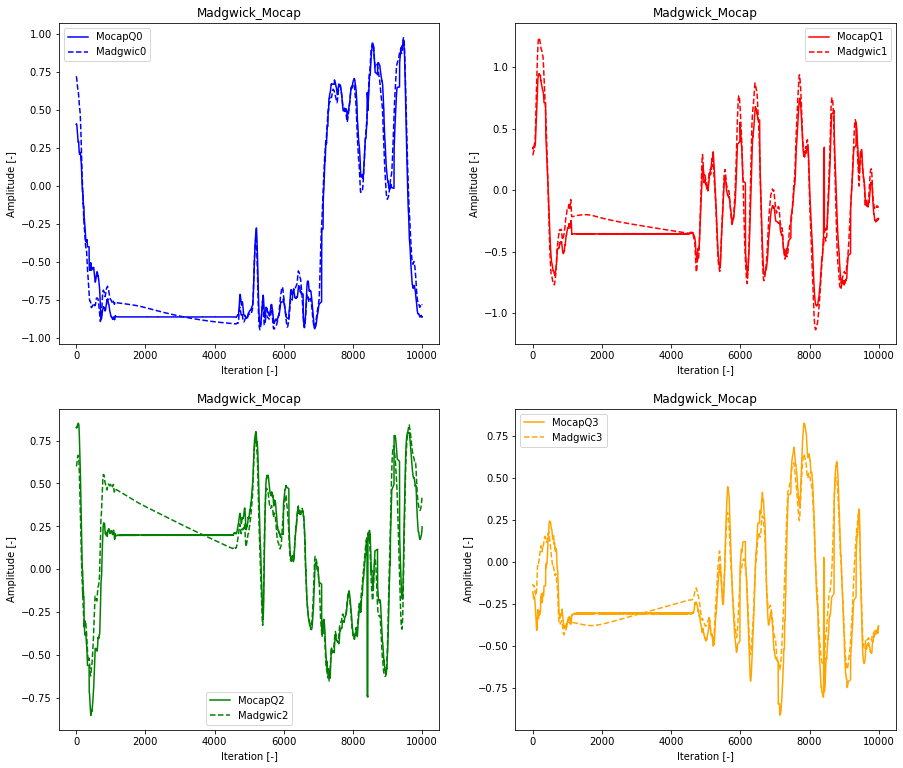

In [20]:
start = 40000
end = 50000

plt.figure(3, figsize=(15, 13))
plt.subplot(221)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,0], color='blue', label='MocapQ0')
plt.plot(MadgwickQ.Q_rel[start:end,0], color='blue', label='Madgwic0',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(222)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,1], color='red', label='MocapQ1')
plt.plot(MadgwickQ.Q_rel[start:end,1], color='red', label='Madgwic1',linestyle='--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(223)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,2], color='green', label='MocapQ2')
plt.plot(MadgwickQ.Q_rel[start:end,2], color='green', label='Madgwic2',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(224)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ_rel[start:end,3], color='orange', label='MocapQ3')
plt.plot(MadgwickQ.Q_rel[start:end,3], color='orange', label='Madgwic3',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()


plt.show()

plt.show()

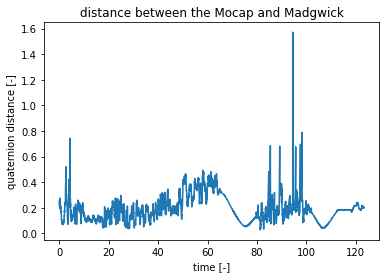

In [25]:
distance_check(MadgwickQ.Q_rel[24800:55600], MocapQ_rel[24800:55600])